In [2]:
import torch
device = torch.cuda.is_available()
print (device)

True


In [5]:
import huggingface_hub
huggingface_hub.notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [4]:
## logging weights, parameters, and hypereparameters
import wandb
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Data Processing

In [6]:
%%capture
!git lfs install
!git clone https://huggingface.co/datasets/datadrivenscience/ship-detection
''' #Using datasets library
from datasets import load_dataset
data = load_dataset("datadrivenscience/ship-detection") '''

In [7]:
import os
import glob
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

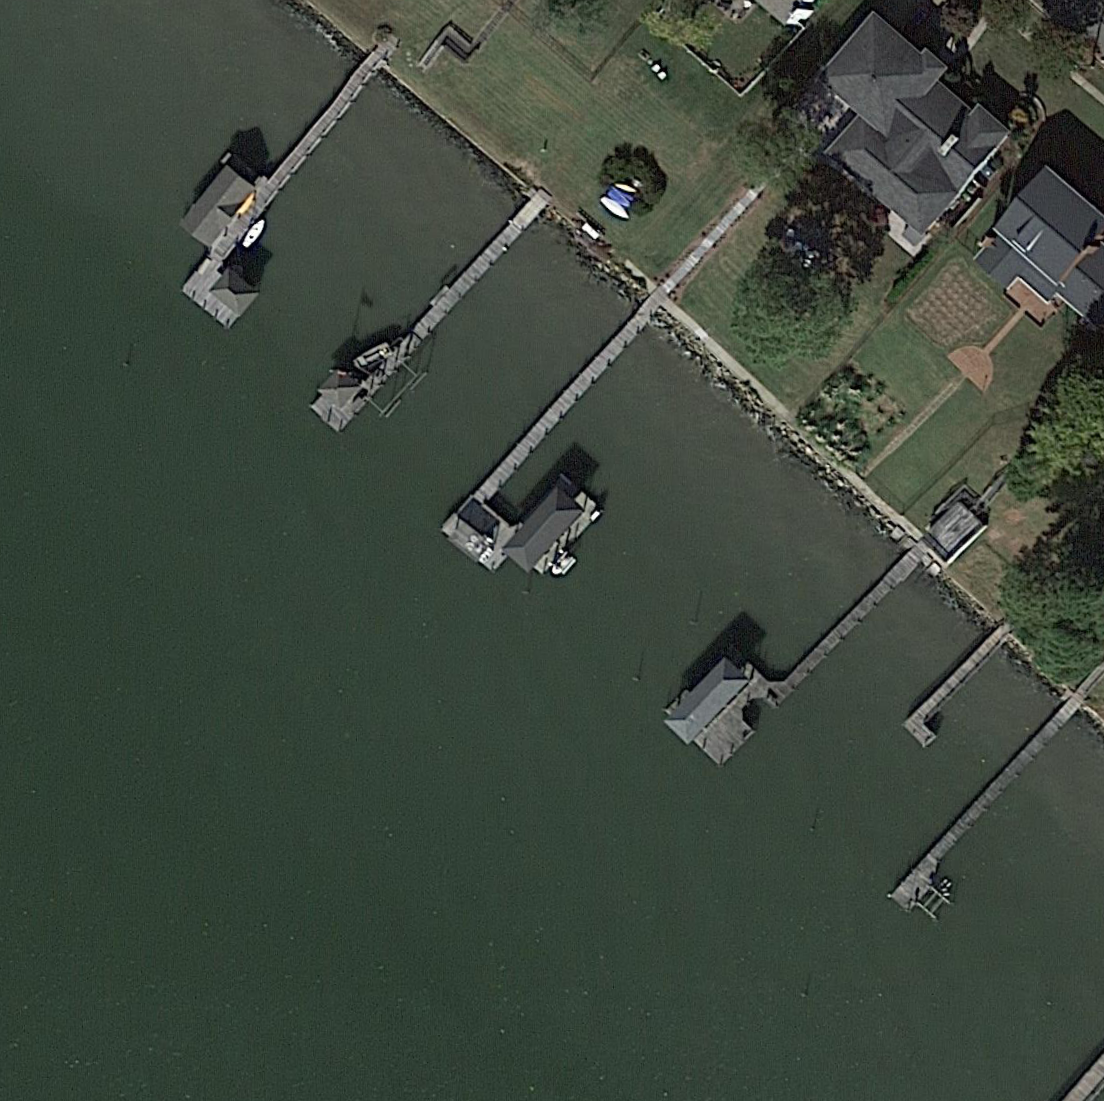

In [ ]:
Image.open("/content/ship-detection/test/106.png")

In [8]:
## define some path variables

ROOT_DIR = "/content/ship-detection"
train_dir = os.path.join(ROOT_DIR, 'train')
train_imgs = glob.glob(train_dir+'/*.png')

test_dir = os.path.join(ROOT_DIR, 'test')
test_imgs = glob.glob(test_dir+'/*.png')

In [9]:
## coin
import json
import pandas as pd
pd.set_option('display.max_columns', None)

## train dataframe
train_metadata = os.path.join(train_dir, 'metadata.jsonl') 

with open(train_metadata, 'r+') as train_objs:
  json_lst = list(train_objs)

bboxes = []
categories = []
filename = []

for obj in json_lst:
  rslt = json.loads(obj)

  bboxes.append(rslt['objects']['bbox'])
  categories.append(rslt['objects']['categories'])
  filename.append(rslt['file_name'])

train_df = pd.DataFrame({
        "filename": filename,
        "bboxes": bboxes,
        "categories": categories, })

train_df['categories'] = train_df['categories'].apply(lambda x: [i+1 for i in x if i == 0]) ## index object label by 1
train_df['filename'] = train_df['filename'].apply(lambda x : os.path.join(train_dir, x))
train_df.head()

,filename,bboxes,categories
0,/content/ship-detection/train/0.png,"[[6690, 3599, 7164, 3850], [6772, 3386, 7039, ...","[1, 1, 1, 1, 1, 1, 1]"
1,/content/ship-detection/train/1.png,"[[613, 18, 619, 31], [668, 33, 681, 39], [666,...","[1, 1, 1, 1, 1]"
2,/content/ship-detection/train/2.png,"[[161, 489, 192, 506], [171, 630, 209, 653]]","[1, 1]"
3,/content/ship-detection/train/3.png,"[[1889, 1463, 2283, 1526], [3953, 1842, 4079, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,/content/ship-detection/train/4.png,"[[747, 2772, 769, 2787], [1007, 2040, 1032, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [10]:
## test dataframe
test_metadata = os.path.join(test_dir, 'metadata.jsonl')

with open(test_metadata, 'r+') as test_objs:
  json_lst = list(test_objs)

bboxes = []
categories = []
filename = []

for obj in json_lst:
  rslt = json.loads(obj)

  bboxes.append(rslt['objects']['bbox'])
  categories.append(rslt['objects']['categories'])
  filename.append(rslt['file_name'])

test_df = pd.DataFrame({
        "filename": filename,
        "bboxes": bboxes,
        "categories": categories, })

test_df['categories'] = test_df['categories'].apply(lambda x: [i+1 for i in x if i == 0]) ## index object label by 1
test_df['filename'] = test_df['filename'].apply(lambda x : os.path.join(test_dir, x))
test_df.tail()

,filename,bboxes,categories
380,/content/ship-detection/test/95.png,"[[100, 100, 110, 130], [80, 80, 90, 100]]","[1, 1]"
381,/content/ship-detection/test/96.png,"[[100, 100, 110, 130], [80, 80, 90, 100]]","[1, 1]"
382,/content/ship-detection/test/97.png,"[[100, 100, 110, 130], [80, 80, 90, 100]]","[1, 1]"
383,/content/ship-detection/test/98.png,"[[100, 100, 110, 130], [80, 80, 90, 100]]","[1, 1]"
384,/content/ship-detection/test/99.png,"[[100, 100, 110, 130], [80, 80, 90, 100]]","[1, 1]"


In [11]:
train_images_metadata = os.path.join(ROOT_DIR, 'train_images.json')
test_images_metadata = os.path.join(ROOT_DIR, 'test_images.json')

train_images = train_df['filename'].tolist()
test_images = test_df['filename'].tolist()

with open(train_images_metadata, 'w+') as trainImgs:
  json.dump(train_images, trainImgs)

with open(test_images_metadata, 'w+') as testImgs:
  json.dump(test_images, testImgs)

In [12]:
## define train objects

train_objects = []

bboxes = train_df['bboxes'].tolist()
labels = train_df['categories'].tolist()

for i in zip(bboxes, labels):
  
  img_object_dict = {}
  img_object_dict['bboxes'] = i[0]
  img_object_dict['labels'] = i[1]

  train_objects.append(img_object_dict)

train_objects_metadata = os.path.join(ROOT_DIR, 'train_objects.json')

with open(train_objects_metadata, 'w+') as trainObjs:
  json.dump(train_objects, trainObjs)

In [13]:
## defining test objects

test_objects = []

bboxes = test_df['bboxes'].tolist()
labels = test_df['categories'].tolist()

for i in zip(bboxes, labels):
  
  img_object_dict = {}
  img_object_dict['bboxes'] = i[0]
  img_object_dict['labels'] = i[1]

  test_objects.append(img_object_dict)

test_objects_metadata = os.path.join(ROOT_DIR, 'test_objects.json')

with open(test_objects_metadata, 'w+') as testObjs:
  json.dump(test_objects, testObjs)

In [ ]:
"""[{"boxes": [[1335, 1387, 1549, 1622], [1780, 1373, 1945, 1578], [2199, 1432, 2379, 1633], [2415, 1482, 2590, 1687], 
            [2705, 1643, 2950, 1913], [3180, 1578, 3450, 1833], [3760, 1247, 4030, 1518], [3145, 1307, 3395, 1522], 
            [3120, 1218, 3275, 1382], [2824, 1327, 3029, 1467], [2420, 1287, 2639, 1432], [2529, 1228, 2674, 1412], 
            [2920, 1183, 3075, 1347], [3455, 1192, 3550, 1262], [3465, 1237, 3655, 1432], [0, 1738, 205, 1955], 
            [1045, 1627, 1435, 1842], [2180, 2077, 2690, 2357], [2149, 1707, 2444, 1872], [1850, 1623, 2140, 1808],
            [1734, 1603, 1895, 1753], [1620, 1597, 1745, 1697], [2959, 1487, 3249, 1688], [3450, 1537, 3795, 1722],
            [2744, 1317, 2839, 1463], [3709, 1167, 3874, 1438], [1644, 122, 2130, 582], [2225, 393, 2684, 578],
            [2724, 472, 3119, 618], [3289, 283, 3824, 502], [2769, 192, 3314, 407], [3650, 9, 4031, 197], [2074, 37, 2769, 283], [699, 177, 1334, 422], 
            [0, 68, 240, 293], [988, 0, 1699, 152]], 
  "labels": [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3]}, 
 
 {"boxes": [[2334, 1448, 2634, 1663], [1894, 1487, 2149, 1717], [2345, 1747, 2795, 2088], [1159, 1518, 1394, 1727], [1155, 1278, 1345, 1452], 
            [1679, 1202, 1864, 1412], [2049, 1178, 2154, 1337], [2244, 1178, 2429, 1398], [925, 1167, 1055, 1278], [799, 1287, 1009, 1408], 
            [369, 1227, 559, 1422], [519, 1182, 669, 1362], [1149, 1192, 1259, 1262], [1409, 1137, 1544, 1227], [1455, 1233, 1640, 1378], 
            [625, 1592, 960, 1918], [320, 1477, 539, 1652], [55, 1417, 329, 1662], [645, 387, 1090, 558], [1219, 323, 1714, 462], [1830, 233, 2400, 407], 
            [2654, 167, 3189, 327], [1429, 22, 2124, 207], [2489, 2, 3194, 97], [575, 138, 1275, 313], [10, 228, 560, 403], [40, 0, 404, 93], 
            [1800, 2498, 2580, 2852], [1655, 1867, 2070, 2102], [2089, 1923, 2344, 2133], [2084, 1468, 2325, 1707], [1389, 1447, 1740, 1652], 
            [925, 1457, 1199, 1642], [14, 1737, 379, 1973], [0, 2132, 615, 2497], [979, 1883, 1189, 2048]], 
  "labels": [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1]}] """

In [ ]:
#Pytorch’s Faster-RCNN implementation requires the annotations (the target in network training) to be a dict with a boxes and a labels key anyway.

### Defining our custom Dataset Class


In [15]:
from torchvision.ops import box_convert
from torch.utils.data import Dataset
from PIL import Image, ImageEnhance
from torchvision import datasets, transforms

import numpy as np
import pathlib
import random
import torch
import json
import cv2
import os


class ShipDataset(torch.utils.data.Dataset):

  def __init__(self, inputs, objects, transform = None) -> None:
    super().__init__()

    self.inputs = inputs
    self.objects = objects
    self.transform = transform    
    assert len(self.inputs) == len(self.objects)

  def __len__(self, ):
    return len(self.inputs)


  def __getitem__(self, index):
    
    # read image
    image = cv2.imread(self.inputs[index], cv2.IMREAD_UNCHANGED)
    if image.shape[-1] == 4:
      image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)


    ## read image objects, bboxes and labels
    ## our data is in 'xmin, ymin, xmax, ymax' which is the same as 'x1, y1, x2, y2'
    objects = self.objects[index]
    bboxes = objects['bboxes'] 
    labels = objects['labels']

    ## apply transforms
    if self.transform is not None:
      transformed = self.transform(image, bboxes, labels)
      image = transformed[0]
      bboxes = transformed[1]
      labels = transformed[2]

    ## convert to tensor
    ## using float16, cause of limited compute power
    image = image.to(torch.float16)
    bboxes = torch.as_tensor(bboxes, dtype=torch.float16)
    labels = torch.as_tensor(labels, dtype=torch.int64)

    target = {
        "boxes": bboxes,
        "labels": labels,}

    return {'image': image, 'target': target}
    

In [16]:

#ShipDataset
import torchvision.transforms.v2 as transforms
import numpy as np
import random
import torch
import json
import os

# get dataset
def get_data(type_="train", split= True, root_folder=None, **kwargs):

  root_folder = "/content/ship-detection"
  with open(os.path.join(root_folder, type_ +"_objects.json" ), 'r+') as json_obj:
    objects = json.load(json_obj)
  with open(os.path.join(root_folder, type_ + "_images.json"), 'r+') as json_imgs:
    images = json.load(json_imgs)


  if split == True:
    ## split train file to train and val
    if kwargs['test_size']:

      train_idx = np.random.choice(len(images), round(len(images)*kwargs['test_size']), replace =False)
      val_idx = np.array(list(set(range(len(images))) - set(train_idx)))

      splt_val_imgs = [images[i] for i in list(val_idx)]
      splt_train_imgs = [images[i] for i in list(train_idx)]

      splt_val_objs = [objects[i] for i in list(val_idx)]
      splt_train_objs = [objects[i] for i in list(train_idx)]

      return splt_train_imgs, splt_val_imgs, splt_train_objs, splt_val_objs
    
    else:
      train_idx = np.random.choice(len(images), round(len(images)*0.8), replace =False)
      val_idx = np.array(list(set(range(len(images))) - set(train_idx)))

      splt_val_imgs = [images[i] for i in list(val_idx)]
      splt_train_imgs = [images[i] for i in list(train_idx)]

      splt_val_objs = [objects[i] for i in list(val_idx)]
      splt_train_objs = [objects[i] for i in list(train_idx)]

      return splt_train_imgs, splt_val_imgs, splt_train_objs, splt_val_objs

  return images, objects


 # Mean for each channel (RGB)
 # Standard deviation for each channel (RGB)



/usr/local/lib/python3.9/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://g

In [ ]:
# Load and transform dataset

transform_train = transforms.Compose([
    #transforms.Resize((800, 800)),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    #transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((800, 800)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

###
train_imgs, val_imgs, train_objs, val_objs = get_data(type_="train", test_size=0.8)
test_imgs, test_objs = get_data(split=False, type_="test")

# Get dataset
train_dataset = ShipDataset(train_imgs, train_objs, transform_train)
val_dataset = ShipDataset(val_imgs, val_objs, transform_train)
test_dataset = ShipDataset(test_imgs, test_objs, transform_test)

In [17]:
def collate_double(batch):
    """
    collate function for the ObjectDetectionDataSet.
    Only used by the dataloader.
    """
    x = [sample['image'] for sample in batch]
    y = [sample['target'] for sample in batch]
    return {"image": x, "target": y}


In [18]:
from torch.utils.data import DataLoader

batch_size=2
num_workers=0

train_dataloader = DataLoader(dataset=train_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=num_workers,
                        collate_fn=collate_double)

val_dataloader = DataLoader(dataset=val_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=num_workers,
                        collate_fn=collate_double)

test_dataloader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=num_workers,
                        collate_fn=collate_double)

In [19]:
data = next(iter(train_dataloader))
for i in data['target']:
  print (i)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Display images with boundary boxes
# get a batch of data
data = next(iter(train_dataloader))

for idx in range(batch_size):

  # get the image and target dictionary
  image = data['image'][idx]
  target = data['target'][idx]

  # undo the normalization and convert back to numpy format
  image = image.cpu().numpy().transpose((1, 2, 0))
  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]
  image = (image * std + mean) * 255.0
  image = image.astype(np.uint8)

  # extract the bounding box coordinates and labels
  bboxes = target['boxes']
  labels = target['labels']

  # plot the image with bounding boxes
  fig, ax = plt.subplots(1)
  ax.imshow(image)
  for bbox, label in zip(bboxes, labels):
      x1, y1, x2, y2 = bbox
      w, h = x2 - x1, y2 - y1
      rect = plt.Rectangle((x1, y1), w, h, fill=False, color='g')
      ax.add_patch(rect)
      #ax.text(x1, y1, s=f"Class {label}", color='white', verticalalignment='top', bbox=dict(facecolor='red', alpha=0.5))
  plt.show()


### Trainng

In [20]:
### Training
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# using transfer learninng on custom model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:04<00:00, 39.4MB/s]


In [21]:
import torch
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import wandb
from tqdm import tqdm

# initialize wandb
wandb.init(project='Ship Detection PT', entity='leumas_tai')

# define hyperparameters
lr = 0.001
momentum = 0.9
num_epochs = 2
batch_size = 2

# get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load pretrained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2 # ship or background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# move the model to the device
model.to(device, torch.half) # FP16 for fast training on colab

wandb: Currently logged in as: leumas_tai. Use `wandb login --relogin` to force relogin


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [23]:

# define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad] # get parameters that need gradient to be cumputed
optimizer = optim.SGD(params, lr=lr, momentum=momentum, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# start training
for epoch in range(num_epochs):

    # set model to training mode
    model.train()

    # initialize losses
    running_loss = 0.0
    running_classification_loss = 0.0
    running_box_regression_loss = 0.0

    # iterate over the train loader
    for batch_idx, batch in enumerate(train_dataloader):

        # move data to device
        print ("Reading in files")
        images = [image.to(device) for image in batch['image']]
        #targets = [{ 'boxes': bbox.to(device), 'labels': label.to(device) } for bbox, label in zip(batch['target']['boxes'], batch['target']['labels'])]
        targets = [{k: v.to(device) for k, v in t.items()} for t in batch['target']]
        
        # forward pass
        print ("Foward propagation")
        loss_dict = model(images, targets)
        classification_loss = loss_dict['loss_classifier']
        box_regression_loss = loss_dict['loss_box_reg']
        losses = classification_loss + box_regression_loss

        # backward pass
        print ("Backward propagation")
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # update running losses
        print ("Update loss")
        running_loss += losses.item()
        running_classification_loss += classification_loss.item()
        running_box_regression_loss += box_regression_loss.item()

        # log batch losses and other metrics to wandb
        print (" log to wandb")
        wandb.log({'Epoch': epoch+1, 'Batch': batch_idx+1, 'Loss': losses.item(), 
                   'Classification Loss': classification_loss.item(),
                   'Box Regression Loss': box_regression_loss.item(),
                   'LR': optimizer.param_groups[0]['lr']})
        
        #if i % 10 == 9:    # print every 10 batches
        #      print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
        #      running_loss = 0.0    

    # update learning rate scheduler
    lr_scheduler.step()

    # log epoch losses and other metrics to wandb
    wandb.log({'Epoch': epoch+1, 'Loss': running_loss/len(train_dataloader), 
               'Classification Loss': running_classification_loss/len(train_dataloader),
               'Box Regression Loss': running_box_regression_loss/len(train_dataloader),
               'LR': optimizer.param_groups[0]['lr']})
    
    print (f"Training loss for epoch {epoch+1} >>>>>>>>>>>>>>>>>>>> {running_loss/len(train_dataloader)} ")

    # Validate model

    # Set model to evaluation mode
    model.eval()
    
    # Initialize validation loss and accuracy
    val_loss = 0.0
    val_step = 0
    
    # Loop over batches in val_dataloader
    for batch_idx, batch in enumerate(val_dataloader):
        with torch.no_grad():
            images = batch['image'].to(device)
            targets = [{ 'boxes': bbox.to(device), 'labels': label.to(device) } for bbox, label in zip(batch['target']['boxes'], batch['target']['labels'])]
            
            # Forward pass
            loss_dict = model(images, targets)
            total_loss = sum(loss for loss in loss_dict.values())
            
            # Update running val loss
            val_loss += total_loss.item()
            val_step += 1

    # Log val loss to wandb
    wandb.log({'val_loss': val_loss / val_step})
    print (f"Validation loss for epoch {epoch+1} >>>>>>>>>>>>>>>>>>>> {val_loss / val_step} ")


Reading in files
Foward propagation
Backward propagation
Update loss
 log to wandb
Reading in files
Foward propagation
Backward propagation
Update loss
 log to wandb
Reading in files
Foward propagation
Backward propagation
Update loss
 log to wandb
Reading in files
Foward propagation
Backward propagation
Update loss
 log to wandb
Reading in files
Foward propagation
Backward propagation
Update loss
 log to wandb
Reading in files
Foward propagation
Backward propagation
Update loss
 log to wandb
Reading in files
Foward propagation
Backward propagation
Update loss
 log to wandb
Reading in files
Foward propagation
Backward propagation
Update loss
 log to wandb
Reading in files
Foward propagation
Backward propagation
Update loss
 log to wandb
Reading in files
Foward propagation
Backward propagation
Update loss
 log to wandb
Reading in files
Foward propagation
Backward propagation
Update loss
 log to wandb
Reading in files
Foward propagation
Backward propagation
Update loss
 log to wandb
Read

OutOfMemoryError: ignored

In [ ]:
#####--------------######-----------------#####---------------

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
running_train_loss = 0.0
running_val_loss = 0.0
train_step = 0
val_step = 0

for epoch in range(num_epochs):
    # Train model
    model.train()
    for i, batch in enumerate(train_dataloader):
        images, targets = batch
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        # Update running train loss
        running_train_loss += losses.item()
        train_step += 1

        # Log train loss to wandb
        wandb.log({'train_loss': running_train_loss / train_step})

    # Validate model
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            images, targets = batch
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # Update running val loss
            running_val_loss += losses.item()
            val_step += 1

    # Log val loss to wandb
    wandb.log({'val_loss': running_val_loss / val_step})

# Test model
model.eval()
test_loss = 0.0
test_step = 0
with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
        images, targets = batch
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Update running test loss
        test_loss += losses.item()
        test


In [ ]:
import torch
import torchvision
import wandb

# Set up WandB for experiment tracking
wandb.init(project="object_detection")

# Define hyperparameters
lr = 0.001
num_epochs = 10
batch_size = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier with a new one that has num_classes = 2 (background + ship)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes=2)

# Move model to device
model.to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Training loop
for epoch in range(num_epochs):
    train_loss = 0.0
    
    # Set model to training mode
    model.train()
    
    # Loop over batches in train_dataloader
    for batch_idx, batch in enumerate(train_dataloader):
        images = batch['image'].to(device)
        print (image.type())
        targets = [{ 'boxes': bbox.to(device), 'labels': label.to(device) } for bbox, label in zip(batch['target']['boxes'], batch['target']['labels'])]
        targets = [{k: v.to(device) for k, v in t.items()} for t in batch['target']]
        
        # Zero out gradients
        optimizer.zero_grad()
        
        # Forward pass
        loss_dict = model(images, targets)
        total_loss = sum(loss for loss in loss_dict.values())
        
        # Backward pass
        total_loss.backward()
        optimizer.step()
        
        # Update running train loss
        train_loss += total_loss.item()
        
        # Log train loss to WandB after every 50 batches
        if (batch_idx + 1) % 50 == 0:
            wandb.log({ 'epoch': epoch + 1, 'train_loss': train_loss / (batch_idx + 1) })
    
    # Calculate average train loss for epoch
    train_loss /= len(train_dataloader)
    
    # Set model to evaluation mode
    model.eval()
    
    # Initialize validation loss and accuracy
    val_loss = 0.0
    val_correct = 0
    
    # Loop over batches in val_dataloader
    for batch_idx, batch in enumerate(val_dataloader):
        with torch.no_grad():
            images = batch['image'].to(device)
            targets = [{ 'boxes': bbox.to(device), 'labels': label.to(device) } for bbox, label in zip(batch['target']['boxes'], batch['target']['labels'])]
            
            # Forward pass
            loss_dict = model(images, targets)
            total_loss = sum(loss for loss in loss_dict.values())
            
            # Update running val loss
            val_loss += total


In [ ]:
import torch
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define the model and optimizer
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2 # background + ship
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Define the device (CPU/GPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define the training loop
num_epochs = 10
for epoch in range(num_epochs):
  running_loss = 0.0
  for i, batch in enumerate(train_dataloader):
    # send data to device
    images = list(image.to(device) for image in batch['image'])
    targets = [{k: v.to(device) for k, v in t.items()} for t in batch['target']]
    
    optimizer.zero_grad()
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())
    losses.backward()
    optimizer.step()
    
    running_loss += losses.item()
    if i % 10 == 9:    # print every 10 batches
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
      running_loss = 0.0


In [ ]:
optimizer = torch
num_epochs = 10

torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
for epochs in range(len(num_epochs)):

  epoch_loss = 0
  for data in train_dataloader:
    imgs = []
    targets = []
    for d in data:
      imgs.append(d[0].to(device))
      targ = {}
      targ['bboxes'] = d[1['bboxes'].to(device)
      targ['labels'] = d[1['labels'].to(device)
      targets.append(targ)

    loss_dict = model(imgs, targets)
    loss = sum(i for i in loss_dict.values()) #summing the whp;e loss i.e classifier and bboxes loss
    print (f"Loss: {loss}")
    epoch_loss = loss.cpu().detach().numpy()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print (f"Epoch {epochs} loss >>>>>>>>>>>>>>>>>>>> {epoch_loss} ")